<a href="https://colab.research.google.com/github/nguyengiapphuongduy/ml-191/blob/master/softmax_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

# Class SoftmaxRegression

In [0]:
class SoftmaxRegression():
    def __init__(self, rate=0.01, max_epoch=1000, tol=1e-4):
        self._tol = tol
        self._rate = rate
        self._max_epoch = max_epoch

    def _softmax(self, arr):
        array2d = np.atleast_2d(arr)
        temp = np.exp(array2d - np.max(array2d, axis=1).reshape(-1, 1))
        return temp/temp.sum(axis=1).reshape(-1, 1)

    def _encode(self, arr):
        ''' one-hot encoding '''

        labels = np.array(arr).reshape(-1, 1)
        self.labels_ = np.unique(labels)
        self.n_classes = len(self.labels_)
        encoded = np.tile([0]*self.n_classes, labels.shape)
        for i in range(self.n_classes):
            indices = np.where(labels==self.labels_[i])[0]
            encoded[indices, i] = 1
        return encoded

    def fit(self, X, y):

        # preparations
        X = np.array(X)
        n_samples, n_features = X.shape
        X = np.column_stack((X, np.ones(n_samples).reshape(-1, 1))) # add bias
        encoded = self._encode(y)

        # randomly initialize W with normal distribution for each row,
        # bias vector is also included
        W = np.concatenate([np.random.randn(n_features + 1).reshape(1, -1)\
                                for _ in range(self.n_classes)])
        # pass the first norm check
        W_prev = W + 1

        # gradient descent
        count, width = 0, 10
        while count < width: # stop criteria
            count = (count + 1) if np.linalg.norm(W - W_prev) < self._tol else 0

            # update W
            Yhat = self._softmax(X.dot(W.T))
            deltaW = (Yhat - encoded).T.dot(X)
            deltaW /= Yhat.shape[0]
            W_prev = W
            W = W - self._rate*deltaW

        # split W into coef_ and intercept_ as in sklearn
        self.coef_ = W[:, :-1]
        self.intercept_ = W[:, -1:].reshape(-1,)
        return self

    def predict(self, X):
        ''' return original labels '''

        return self.labels_[self._eval(X)]

    def _eval(self, X):
        ''' apply weights and softmax '''

        X = np.array(X)
        bias = np.tile(self.intercept_, (X.shape[0], 1))
        Yhat = self._softmax(X.dot(self.coef_.T) + bias)
        return np.argmax(Yhat, axis=1)


# Apply

### Generate inputs

Use ```np.random.multivariate_normal``` to create points of 3 classes data. Means are $(1,1), (5,6), (3,7)$ respectively

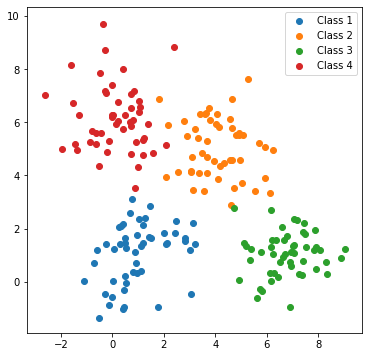

In [0]:
num_class1, num_class2, num_class3 = 50, 50, 50
class1 = np.random.multivariate_normal([1, 1], [[1, 0], [0, 1]], num_class1)
class2 = np.random.multivariate_normal([4, 5], [[1, 0], [0, 1]], num_class2)
class4 = np.random.multivariate_normal([0, 6], [[1, 0], [0, 1]], num_class2)
class3 = np.random.multivariate_normal([7, 1], [[1, 0], [0, 1]], num_class3)
samples = np.concatenate((class1, class2, class3, class2))
labels = np.concatenate((['Class 1']*num_class1,
                         ['Class 2']*num_class2,
                         ['Class 3']*num_class3,
                         ['Class 4']*num_class2))
N = samples.shape[0]

plt.figure(figsize=(6,6))
plt.scatter(class1[:,0], class1[:,1], label='Class 1')
plt.scatter(class2[:,0], class2[:,1], label='Class 2')
plt.scatter(class3[:,0], class3[:,1], label='Class 3')
plt.scatter(class4[:,0], class4[:,1], label='Class 4')
plt.legend()
pass

### Fit

In [0]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
sk_model.fit(samples, labels)

my_model = SoftmaxRegression(rate=0.1)
my_model.fit(samples, labels)

pass

### Plot and compare the results

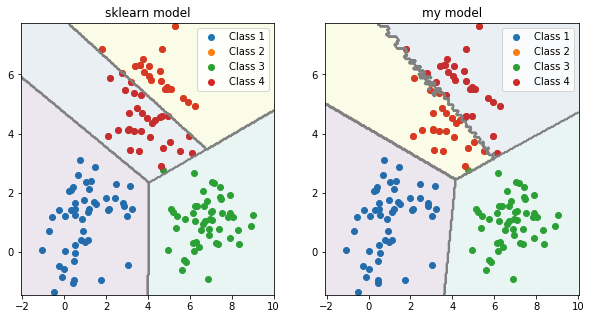

In [0]:
def plot_result(fig, ax, model, X, y):
    '''Predict and color the sample space'''
    left, right = X[:,0].min() - 1, X[:,0].max() + 1
    bot, top = X[:,1].min() - 0.1, X[:,1].max() + 0.1
    ax.set_xlim((left, right))
    ax.set_ylim((bot, top))

    xx, yy = np.mgrid[left:right:0.05, bot:top:0.05]
    space = np.dstack((xx.ravel(), yy.ravel()))[0]
    pred = model.predict(space).reshape(xx.shape)
    i = 0
    for label in np.unique(y):
        pred[pred==label] = i
        Xclass = X[y==label]
        ax.scatter(Xclass[:, 0], Xclass[:, 1], label=label)
        i += 1

    ax.contourf(xx, yy, pred, alpha=0.1)
    ax.contour(xx, yy, pred, colors=['gray'])
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_result(fig, ax[0], sk_model, samples, labels)
plot_result(fig, ax[1], my_model, samples, labels)
ax[0].set_title('sklearn model')
ax[1].set_title('my model')
pass